In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor


In [2]:
df=pd.read_csv('1.3gurgaon_properties_post_feature_selection_v2.csv')

In [3]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [32]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2349
1.0    1018
2.0     187
Name: count, dtype: int64

In [33]:
# 0.0 - unfurnished
# 1.0- semifurnished
# 0.2 - furnished
df['furnishing_type']=df['furnishing_type'].replace({0.0:'unfurnished',
                                                     1.0:'semifurnished',
                                                     2.0:'furnished'}
                                                   )

In [34]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


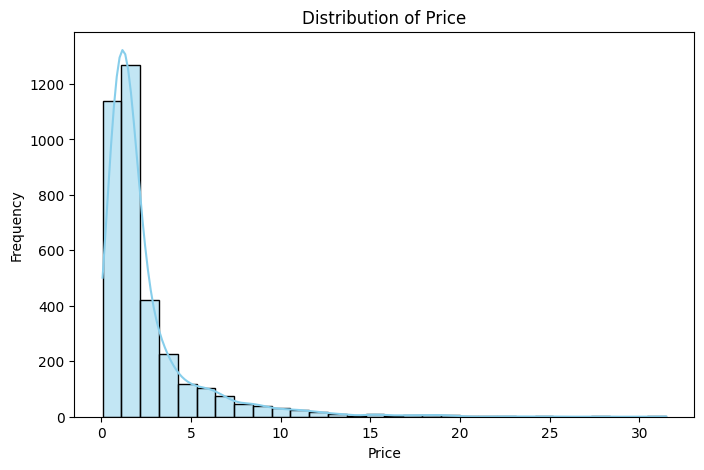

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


In [36]:
skew_value = df['price'].skew()
print("Skewness:", skew_value)


Skewness: 3.3009203802727045


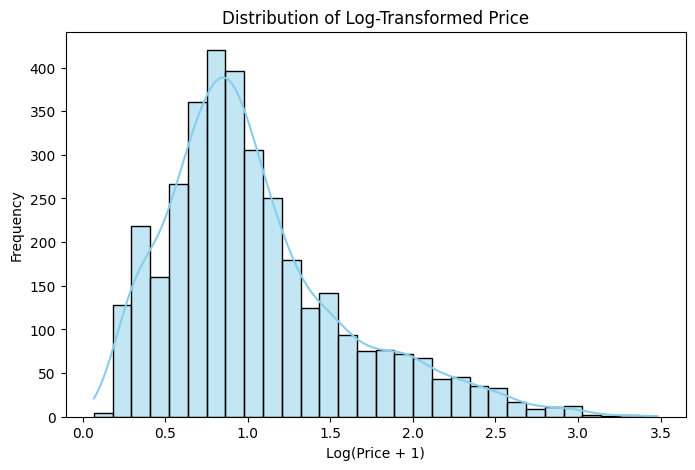

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 5))
sns.histplot(np.log1p(df['price']), kde=True, bins=30, color='skyblue')
plt.title("Distribution of Log-Transformed Price")
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.show()


In [38]:
X = df.drop(columns=['price'])
y = df['price']

In [39]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

## Ordinal Encoding

In [40]:
columns_to_encode = ['property_type','sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [41]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ], 
    remainder='passthrough'
)

In [42]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [43]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [44]:
scores.mean(),scores.std()

(0.7363096633436828, 0.03238005754429935)

In [45]:

X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [46]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [64]:
y_pred = pipeline.predict(X_test)

In [65]:
y_pred = np.expm1(y_pred)

In [66]:
mean_absolute_error(np.expm1(y_test),y_pred)

0.9463822160089356

In [67]:
def scorer(model_name, model):
    
    output = []
    
    output.append(model_name)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # K-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)
    
    pipeline.fit(X_train,y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test),y_pred))
    
    return output
    

In [68]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees': ExtraTreesRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [69]:
model_output = []
for model_name,model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [70]:
model_output

[['linear_reg', 0.7363096633436828, 0.9463822160089356],
 ['svr', 0.7642012011196353, 0.8472636473483922],
 ['ridge', 0.7363125343993554, 0.9463387741853366],
 ['LASSO', 0.05943378064493573, 1.528905986892753],
 ['decision tree', 0.7664249409050858, 0.7396391426265387],
 ['random forest', 0.8815696506810848, 0.5345608940693108],
 ['extra trees', 0.8676644338805971, 0.552217719228812],
 ['gradient boosting', 0.8726638549467409, 0.5766604654561651],
 ['adaboost', 0.7509875807426377, 0.8215166186229521],
 ['mlp', 0.8046667020885128, 0.7181662754776132],
 ['xgboost', 0.8894876835260124, 0.5040475141482346]]

In [71]:
model_df = pd.DataFrame(model_output, columns=['name','r2','mae'])

In [72]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.889488,0.504048
5,random forest,0.881570,0.534561
6,extra trees,0.867664,0.552218
7,gradient boosting,0.872664,0.576660
9,mlp,0.804667,0.718166
4,decision tree,0.766425,0.739639
8,adaboost,0.750988,0.821517
1,svr,0.764201,0.847264
2,ridge,0.736313,0.946339
0,linear_reg,0.736310,0.946382
